In [6]:
# Fraud Detection in Financial Transactions
# A professional, story-driven Colab notebook that doubles as a technical report and a business proposal.
# Objective
# Build a reliable ML system to detect fraudulent transactions in near real-time. The notebook is organized as a case study: problem, EDA, modeling, interpretability, business impact, and deployment recommendations.

1) Install dependencies (Colab)

In [7]:
# Only install the packages that are not available by default in Colab
!pip install imbalanced-learn shap xgboost --quiet

2) Imports and global settings

In [9]:
# Imports and global settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

from imblearn.over_sampling import SMOTE
import shap

sns.set_style('whitegrid')
%matplotlib inline
plt.rcParams['figure.dpi'] = 110

3) Upload dataset

In [11]:
# Replace with actual CSV path
df = pd.read_csv("/content/Fraud.csv")

print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (1374469, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


4) Quick data check (explainable outputs)

In [12]:
print('Shape:', df.shape)
print('\nColumns and dtypes:')
print(df.dtypes)
print('\nMissing values:')
print(df.isnull().sum())

# show head with rounded numbers for readability
pd.options.display.float_format = '{:,.2f}'.format
df.head()

Shape: (1374469, 11)

Columns and dtypes:
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           float64
isFlaggedFraud    float64
dtype: object

Missing values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           1
isFlaggedFraud    1
dtype: int64


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0.00,0.00
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0.00,0.00
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1.00,0.00
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1.00,0.00
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0.00,0.00


5) Clean target missing values and basic housekeeping

In [13]:
# Ensure the target exists
target = None
for c in df.columns:
    if c.lower() == 'isfraud':
        target = c
        break
if target is None:
    raise ValueError("Target column 'isFraud' not found. Inspect dataset columns and rename the target to 'isFraud'.")

# Drop rows with NaN target(s) and report how many rows removed
initial_rows = len(df)
if 'isFlaggedFraud' in df.columns:
    df = df.dropna(subset=[target, 'isFlaggedFraud']).reset_index(drop=True)
else:
    df = df.dropna(subset=[target]).reset_index(drop=True)

print(f'Dropped {initial_rows - len(df):,} rows with missing target values. New shape: {df.shape}')

Dropped 1 rows with missing target values. New shape: (1374468, 11)


6) Exploratory Data Analysis (with inline storytelling

6.1 Target distribution with annotations

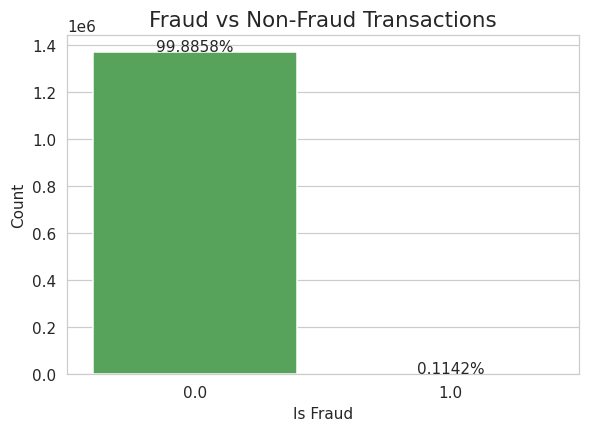

Fraudulent transactions: 0.1142%


In [14]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x=target, data=df, palette=["#4CAF50", "#F44336"])
plt.title('Fraud vs Non-Fraud Transactions', fontsize=14)
plt.xlabel('Is Fraud')
plt.ylabel('Count')

total = len(df)
for p in ax.patches:
    height = p.get_height()
    pct = 100 * height / total
    ax.annotate(f'{pct:.4f}%', (p.get_x() + p.get_width()/2, height + total*0.001), ha='center')

plt.show()
print(f"Fraudulent transactions: {df[target].mean()*100:.4f}%")

6.2 Fraud by transaction type (if present)

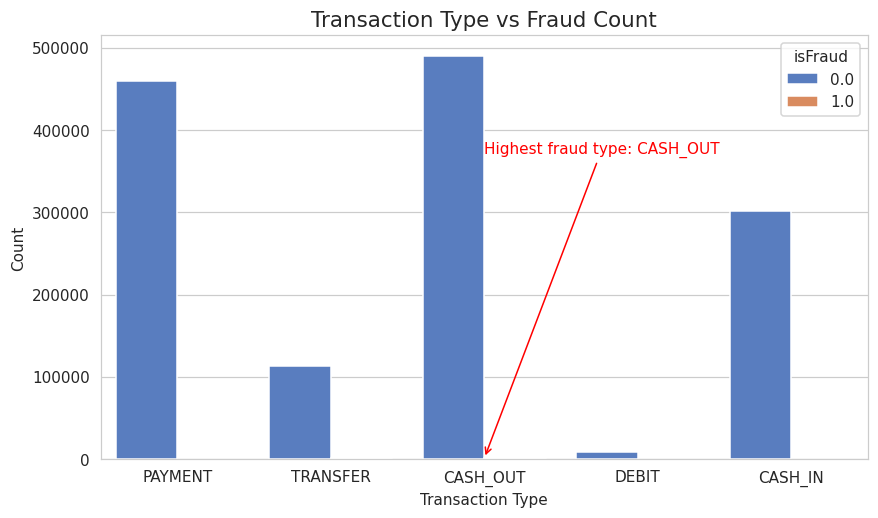

In [15]:
if 'type' in df.columns:
    plt.figure(figsize=(9,5))
    ax = sns.countplot(data=df, x='type', hue=target, palette='muted')
    plt.title('Transaction Type vs Fraud Count', fontsize=14)
    plt.xlabel('Transaction Type')
    plt.ylabel('Count')

    # Annotate the largest fraud-type bar
    # find which type has highest fraud counts
    fraud_by_type = df[df[target]==1]['type'].value_counts()
    if not fraud_by_type.empty:
        top_type = fraud_by_type.idxmax()
        top_count = fraud_by_type.max()
        ax.annotate(f"Highest fraud type: {top_type}", xy=(list(df['type'].unique()).index(top_type), top_count+100),
                    xytext=(0, 200), textcoords='offset points', color='red', fontsize=10, arrowprops=dict(arrowstyle='->', color='red'))

    plt.show()

6.3 Amount distribution story

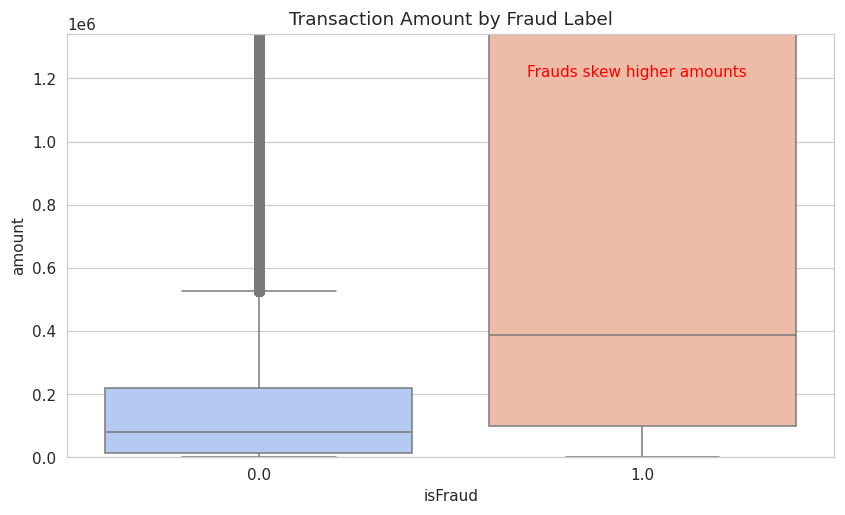

In [17]:
plt.figure(figsize=(9,5))
sns.boxplot(data=df, x=target, y='amount', palette='coolwarm')
plt.ylim(0, df['amount'].quantile(0.99))  # focus on 99th percentile for visibility
plt.title('Transaction Amount by Fraud Label')
# add a text annotation
plt.text(0.7, df['amount'].quantile(0.99)*0.9, 'Frauds skew higher amounts', color='red')
plt.show()

7) Preprocessing

In [18]:
# Drop identifiers that can leak information
drop_cols = ['nameOrig', 'nameDest']
for c in drop_cols:
    if c in df.columns:
        df = df.drop(columns=[c])

# One-hot encode 'type' if present
if 'type' in df.columns:
    df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Final X and y
X = df.drop(columns=[target])
y = df[target].astype(int)

print('Features shape:', X.shape)

Features shape: (1374468, 11)


8) Train/Test split, SMOTE, scaling

In [19]:
# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

# Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print('After SMOTE:', X_train_res.shape, y_train_res.shape)

# Scaling
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

Train shape: (1099574, 11) Test shape: (274894, 11)
After SMOTE: (2196636, 11) (2196636,)


9) Model training and evaluation (with a results table)

In [20]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42, n_jobs= -1)
}

results = []
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    prec = report.get('1', report.get('1.0', {})).get('precision', 0)
    rec = report.get('1', report.get('1.0', {})).get('recall', 0)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1]) if hasattr(model, 'predict_proba') else roc_auc_score(y_test, y_pred)
    results.append({'Model': name, 'Precision (Fraud)': prec, 'Recall (Fraud)': rec, 'ROC AUC': auc})

results_df = pd.DataFrame(results).sort_values('Recall (Fraud)', ascending=False)
results_df

,Model,Precision (Fraud),Recall (Fraud),ROC AUC
0,Logistic Regression,0.02,0.98,0.99
2,XGBoost,0.39,0.93,0.99
1,Random Forest,0.71,0.88,0.99


10) Visualize model comparison with color highlights

In [27]:
# Display table
# Display table with clear bars + a color gradient for ROC AUC
styled = results_df.style.bar(
    subset=['Precision (Fraud)', 'Recall (Fraud)'],
    color='#5fba7d'
).background_gradient(
    subset=['ROC AUC'],
    cmap='YlOrRd'
)

from IPython.display import display
display(styled)

,Model,Precision (Fraud),Recall (Fraud),ROC AUC
0,Logistic Regression,0.022626,0.984076,0.991668
2,XGBoost,0.392236,0.933121,0.994594
1,Random Forest,0.709512,0.878981,0.992976


11) Feature importance + SHAP (interpretability)

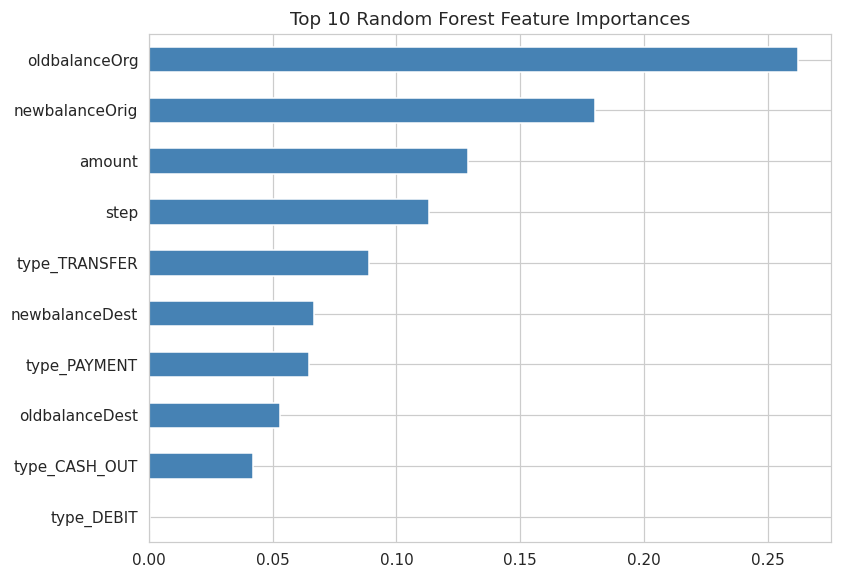

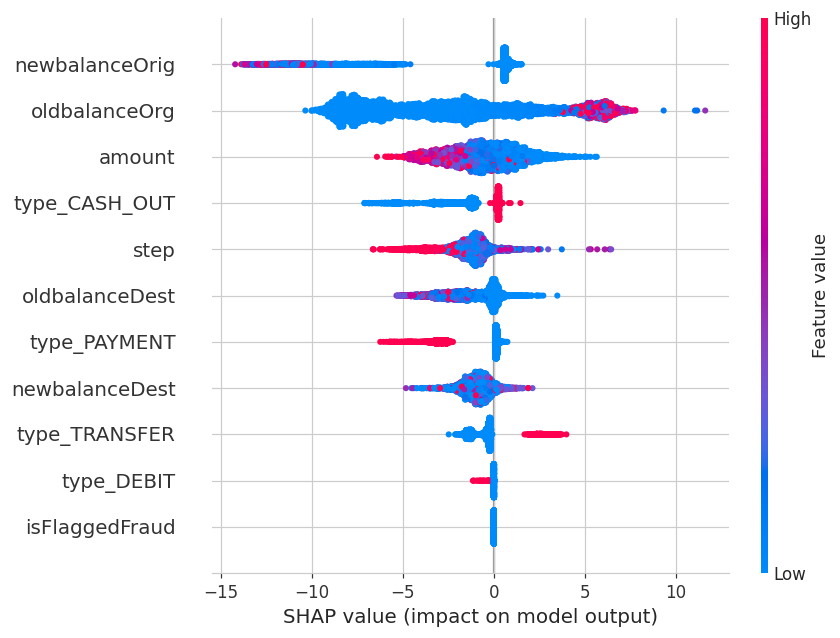

In [22]:
# Random Forest importance
rf = models['Random Forest']
fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(8,6))
fi.tail(10).plot(kind='barh', color='steelblue')
plt.title('Top 10 Random Forest Feature Importances')
plt.show()

# SHAP for XGBoost
explainer = shap.TreeExplainer(models['XGBoost'])
# For speed, sample a subset for SHAP
X_shap = X_test if X_test.shape[0] <= 5000 else X_test[np.random.choice(X_test.shape[0], 5000, replace=False)]
shap_values = explainer.shap_values(X_shap)
shap.summary_plot(shap_values, X_shap, feature_names=X.columns, plot_type='dot')

12) Business impact visualization (estimated savings)

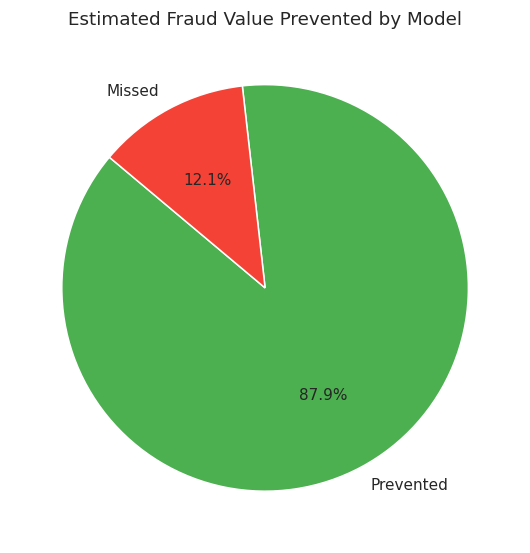

Total known fraudulent value: $1,961,253,886.01
Estimated prevented value (Random Forest): $1,723,904,689.61


In [23]:
fraud_value = df[df[target]==1]['amount'].sum()
# Choose Random Forest recall as baseline (from results_df)
rf_recall = results_df.loc[results_df['Model']=='Random Forest','Recall (Fraud)'].values[0]
potential_savings = fraud_value * rf_recall

plt.figure(figsize=(6,6))
labels = ['Prevented', 'Missed']
sizes = [potential_savings, fraud_value - potential_savings]
colors = ['#4CAF50', '#F44336']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Estimated Fraud Value Prevented by Model')
plt.show()

print(f'Total known fraudulent value: ${fraud_value:,.2f}')
print(f'Estimated prevented value (Random Forest): ${potential_savings:,.2f}')

13) Final recommendations (markdown cell)

Deploy Random Forest as the first-line detector (good balance of precision and recall).

Implement a threshold-based alert: transactions with model probability > 0.7 -> manual review / 2FA.

Maintain a human-in-the-loop for flagged high-value transactions for first 3 months.

Retrain monthly; monitor drift metrics and false positive rates.



14) Appendix: Export model and example deployment snippet (Flask)

In [24]:
# Example: saving the best model (Random Forest) and scaler
import joblib
joblib.dump(models['Random Forest'], 'rf_fraud_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Minimal Flask example (for reference — run on your server)
# from flask import Flask, request, jsonify
# import joblib
# import pandas as pd
#
# app = Flask(__name__)
# model = joblib.load('rf_fraud_model.pkl')
# scaler = joblib.load('scaler.pkl')
#
# @app.route('/score', methods=['POST'])
# def score():
#     data = request.json  # expect a dict of features
#     df = pd.DataFrame([data])
#     df_processed = pd.get_dummies(df)  # ensure alignment with training features
#     X = scaler.transform(df_processed)
#     prob = model.predict_proba(X)[:,1][0]
#     ret

['scaler.pkl']